# Logistic Regression

## Import libraries

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, 
    log_loss, precision_recall_curve, auc, brier_score_loss
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # Import SMOTE for handling imbalanced data
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline as imba_Pipeline
from scipy.stats import loguniform
import gradio as gr


## Load dataset

In [29]:
crime = pd.read_csv('crime_dumscalab.csv')
crime = pd.DataFrame(crime)
## age is still between 0 and 100


## Create a scaler instance for 'victim age'

In [31]:
scaler = StandardScaler()
crime['Victim Age Scaled'] = scaler.fit_transform(crime[['Victim Age']])

## Define variables and split dataset

In [33]:
# Prepare the model's feature data (X) and target variable (y)
X_dummy = crime.drop(columns=['Unnamed: 0','Victim Age', 'Weapon Category','Weapon Category.1'])
y_dummy = crime['Weapon Category.1']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=42, stratify=y_dummy)


Notes (ChatGPT):

The stratify parameter is used to ensure that the proportion of target class labels in the training and test datasets matches the proportion of the target class labels in the original dataset. This is especially important when working with imbalanced datasets, where one class significantly outnumbers another.

Where Is stratify Used? In Data Splitting: When using train_test_split from sklearn.model_selection, the stratify parameter helps maintain class proportions between the training and test sets. Example:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y )

If y has 70% of class 0 and 30% of class 1 in the original dataset, both the training and test sets will retain this 70:30 ratio when stratify=y.

Why Is stratify Important? 

Preserves Class Distribution: Ensures that both training and test sets have a similar distribution of target classes. This is crucial for imbalanced datasets, where the model might otherwise end up training only on the majority class if class proportions are not preserved. 

Prevents Sampling Bias: Without stratification, the split might accidentally over-represent one class in either the training or test set, leading to biased evaluation. Improves Model Evaluation: When the test set reflects the original dataset's class distribution, the model's performance metrics (e.g., accuracy, precision, recall) are more reliable and realistic. 

Use Cases of Stratification: Classification Problems: To balance class proportions between training and test datasets. Example: When predicting rare diseases, stratification ensures the rare disease class isn't missing from the test set. 

Cross-Validation: In stratified k-fold cross-validation, the folds are created such that the class proportions are maintained in each fold. Example: from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

Imbalanced Datasets: When classes are highly imbalanced (e.g., 95% to 5%), stratification ensures that both training and testing have examples of the minority class, making training and evaluation meaningful. 

When Not to Use stratify? 

For Regression Problems: Stratify is not relevant for continuous targets, as it is designed for classification tasks with discrete categories. 

When Class Imbalance Is Not a Concern: If the target variable is already evenly distributed, stratification is not necessary. By using stratify wisely, you can ensure more robust and fair model training and evaluation, particularly for classification tasks.

## Implementation of a random Logistic Regression model

Accuracy: 0.6158639857558518
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.58      0.50     15157
           1       0.75      0.64      0.69     30897

    accuracy                           0.62     46054
   macro avg       0.60      0.61      0.59     46054
weighted avg       0.65      0.62      0.63     46054

Precision: 0.7535714285714286
Recall: 0.6351102048742596
F1 Score: 0.6892881605985564


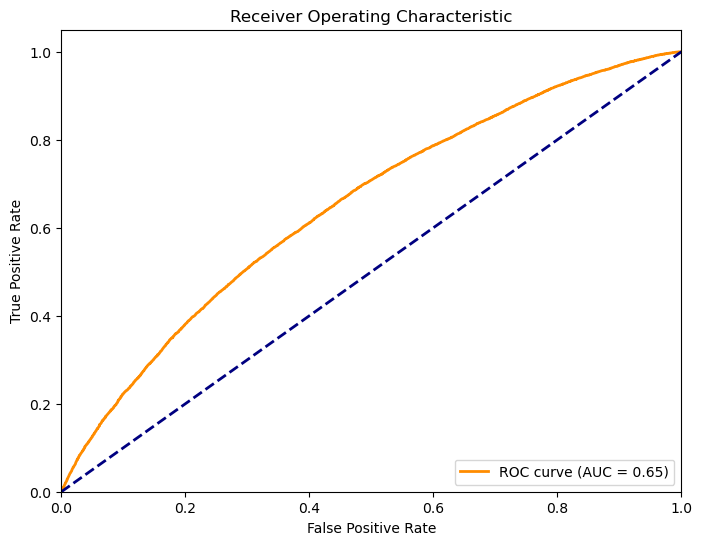

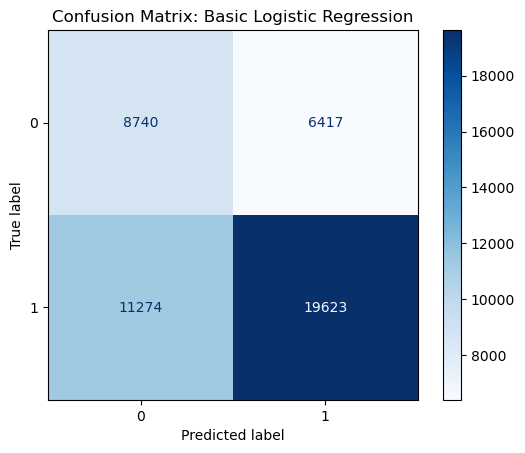

Optimization terminated successfully.
         Current function value: 0.601911
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Weapon Category.1   No. Observations:               107457
Model:                          Logit   Df Residuals:                   107440
Method:                           MLE   Df Model:                           16
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                 0.04994
Time:                        17:53:43   Log-Likelihood:                -64680.
converged:                       True   LL-Null:                       -68080.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.8558      0.043    

In [35]:
# Initialize the logistic regression model
model = LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced')
## parameters and their arguments or values chosen at random
# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate: Precision, Recall & F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: Basic Logistic Regression")
plt.show()

import statsmodels.api as sm

# Add an intercept to the features
X_train_sm = sm.add_constant(X_train)

# Fit a logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Display the summary of the model
print(logit_model.summary())

## Search for best parameters without SMOTE

### Search for best model across Logistic Regression, Lasso and Ridge options

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=No

Accuracy: 0.6851087853389499
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.16      0.25     15157
           1       0.70      0.94      0.80     30897

    accuracy                           0.69     46054
   macro avg       0.64      0.55      0.52     46054
weighted avg       0.66      0.69      0.62     46054

Precision: 0.6954344975563238
Recall: 0.9441046056251416
F1 Score: 0.8009115620109277


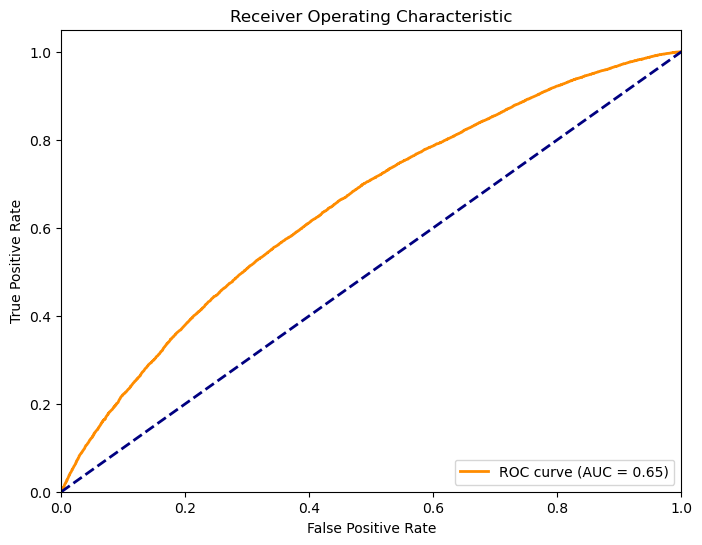

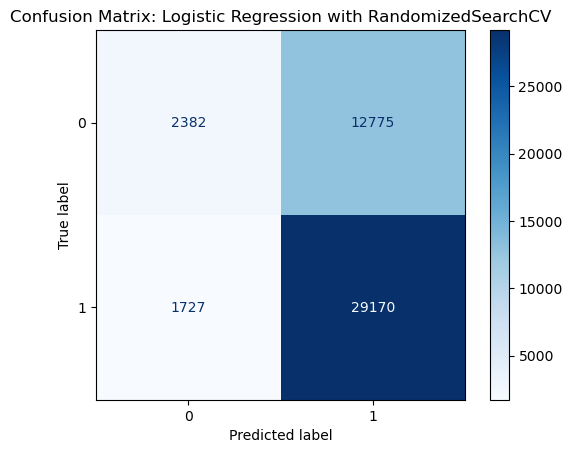

Best Parameters: {'C': 5.953896264004558, 'class_weight': None, 'max_iter': 3000, 'penalty': None, 'solver': 'saga'}
Optimization terminated successfully.
         Current function value: 0.601911
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Weapon Category.1   No. Observations:               107457
Model:                          Logit   Df Residuals:                   107440
Method:                           MLE   Df Model:                           16
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                 0.04994
Time:                        17:54:10   Log-Likelihood:                -64680.
converged:                       True   LL-Null:                       -68080.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [37]:
# Perform RandomizedSearchCV for best model

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-4, 1e4),  # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers to test
    'max_iter': [1000, 2000, 3000],  # Maximum iterations
    'penalty': ['l2', 'l1', None],  # Penalty types
    'class_weight': ['balanced', None],  # Handle class imbalance
}

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Initialize RandomizedSearchCV with logistic regression and the parameter grid
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=1)

# Fit the model using RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)


# Get the best estimator found by RandomizedSearchCV

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)


# Evaluate model performance

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate: Precision, Recall & F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Predict probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: Logistic Regression with RandomizedSearchCV")
plt.show()

# Print the best parameters found by RandomizedSearchCV
print(f"Best Parameters: {random_search.best_params_}")


# Apply statsmodels for regression statistics

# Add constant to the features to include the intercept term
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression model using statsmodels Logit
log_reg_sm = sm.Logit(y_train, X_train_sm)
result = log_reg_sm.fit()

# Print the regression summary
print(result.summary())



Notes (ChatGPT):

With argument n_jobs = -1, I was getting the following error: BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

Explanation: The BrokenProcessPool error typically occurs when the arguments passed to RandomizedSearchCV (or similar parallelized processes) are not serializable (picklable). This issue arises because n_jobs=-1 enables parallel processing, but Python's multiprocessing module requires everything passed to the worker processes to be serializable.

How I fixed it: The change from n_jobs=-1 to n_jobs=1 in the RandomizedSearchCV function affects how the parallelism is handled when training the model. Let's break this down:

What does n_jobs do? The n_jobs parameter in RandomizedSearchCV controls how many CPU cores will be used during the fitting process. Here’s what different values mean:

n_jobs=1: This means that the process will use only one core (no parallelization). The search will happen sequentially, where each combination of hyperparameters is tested one after the other. n_jobs=-1: This means that all available CPU cores will be used for parallelization. The process will divide the work across all cores to test multiple hyperparameter combinations in parallel, speeding up the search process, especially for large datasets or complex models. 

Why change to n_jobs=1? There are a few possible reasons you might change from n_jobs=-1 to n_jobs=1:

Resource Management: If you're working in an environment where resource usage needs to be controlled or if you are running the code on a machine with limited resources, setting n_jobs=1 ensures that only one CPU core is used, reducing the load on your system. This is particularly relevant if you're working in shared environments like cloud services or on a system where you don’t want to monopolize CPU resources. 

Debugging or Stability: In some cases, when you are debugging or testing code, you might want to set n_jobs=1 to simplify the execution and avoid issues related to parallel execution. Parallelization can sometimes introduce issues related to thread management or resource contention, and using a single thread helps isolate such issues. 

Known Issues with Parallelism: Some environments or libraries may have specific issues with parallel execution (especially with n_jobs=-1), such as problems with managing multiple threads or processes, which can lead to crashes or memory issues. In such cases, using n_jobs=1 can help avoid those problems. 

When should you set n_jobs=-1? 

For faster computation: If you have a powerful machine with multiple cores and you want to speed up the search process, you can set n_jobs=-1. This will allow RandomizedSearchCV to run multiple combinations of hyperparameters simultaneously, reducing the time it takes to complete the search. 

When using larger datasets: If you are training on large datasets or complex models, parallelizing the search can significantly reduce training time. 

Conclusion: The choice between n_jobs=1 and n_jobs=-1 depends on your priorities (e.g., resource management vs. computation speed). In your case, the change to n_jobs=1 may have been made to avoid potential issues with parallelization or to better manage system resources. If you want to speed up the search and are confident that your system can handle it, you can change it back to n_jobs=-1.

## Search for best parameters with SMOTE

### Search for best model across Logistic Regression, Lasso and Ridge options

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=No

Accuracy: 0.6161028358014504
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.58      0.50     15157
           1       0.75      0.64      0.69     30897

    accuracy                           0.62     46054
   macro avg       0.60      0.61      0.59     46054
weighted avg       0.65      0.62      0.63     46054

Precision: 0.7537339220579766
Recall: 0.6353691296889665
F1 Score: 0.6895086228091742


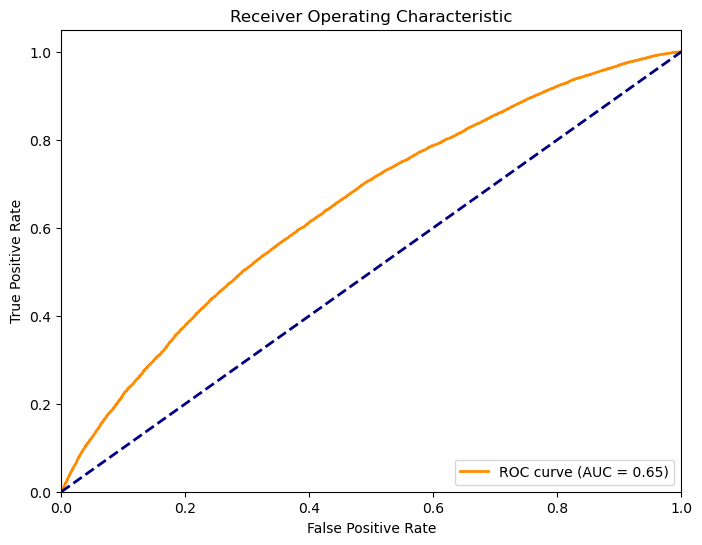

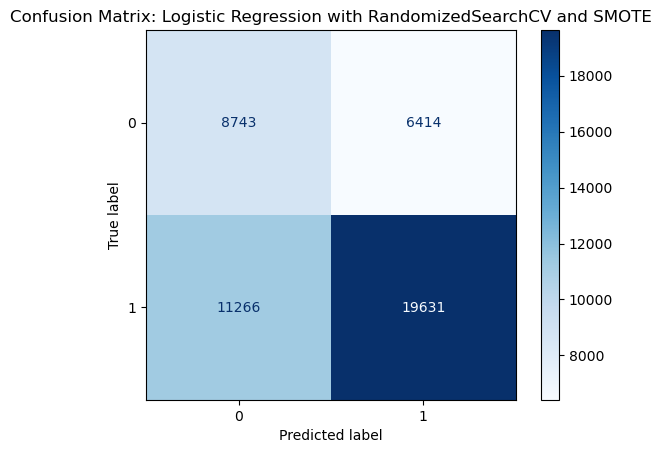

Best Parameters: {'log_reg__C': 0.15808394808776696, 'log_reg__class_weight': None, 'log_reg__max_iter': 3000, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Optimization terminated successfully.
         Current function value: 0.601911
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Weapon Category.1   No. Observations:               107457
Model:                          Logit   Df Residuals:                   107440
Method:                           MLE   Df Model:                           16
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                 0.04994
Time:                        17:56:29   Log-Likelihood:                -64680.
converged:                       True   LL-Null:                       -68080.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0

In [39]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'log_reg__C': loguniform(1e-4, 1e4),  # Regularization strength for Logistic Regression
    'log_reg__solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers to test for Logistic Regression
    'log_reg__max_iter': [1000, 2000, 3000],  # Maximum iterations for Logistic Regression
    'log_reg__penalty': ['l2', 'l1', None],  # Penalty types for Logistic Regression
    'log_reg__class_weight': ['balanced', None],  # Handle class imbalance for Logistic Regression
}

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)

# Create an imbalanced pipeline with SMOTE and Logistic Regression
imbalanced_pipeline = imba_Pipeline([
    ('smote', smote),  # Apply SMOTE oversampling
    ('log_reg', log_reg)  # Logistic Regression model
])

# Initialize RandomizedSearchCV with logistic regression and the parameter grid
random_search = RandomizedSearchCV(
    imbalanced_pipeline, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5,  # 5-fold cross-validation
    random_state=42, 
    n_jobs=1,  # Set to -1 for using all cores
    scoring='roc_auc' # Use AUC-ROC as the scoring metric
)

# Fit the model using RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)


# Step 5: Get the best estimator found by RandomizedSearchCV

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)


# Step 6: Evaluate model performance

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate: Precision, Recall & F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Predict probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: Logistic Regression with RandomizedSearchCV and SMOTE")
plt.show()

# Print the best parameters found by RandomizedSearchCV
print(f"Best Parameters: {random_search.best_params_}")


# Step 7: Apply statsmodels for regression statistics

# Add constant to the features to include the intercept term
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression model using statsmodels Logit
log_reg_sm = sm.Logit(y_train, X_train_sm)
result = log_reg_sm.fit()

# Print the regression summary
print(result.summary())


Notes (ChatGPT):

Using scoring='roc_auc' in your RandomizedSearchCV is an excellent choice when your dataset is imbalanced. Here's why:

Why Use roc_auc for Imbalanced Data?

Sensitivity to Class Imbalance: Metrics like accuracy can be misleading for imbalanced datasets because the model might predict the majority class most of the time and still achieve high accuracy.

AUC-ROC Focus: The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) measures the model's ability to distinguish between classes. It evaluates how well the model ranks positive examples higher than negative ones, irrespective of the classification threshold.
Threshold-Independent: AUC-ROC does not rely on a specific threshold for classification, making it a robust metric for imbalanced datasets.

Alternatives for Scoring

Depending on your use case, you might also consider:

average_precision: This is based on the precision-recall curve and is another good choice for imbalanced data.

f1: If you are particularly concerned about the balance between precision and recall.

recall: If the cost of missing a positive case is high (e.g., failing to identify a firearm case).

Ensuring Best Results

Since you are using SMOTE to address class imbalance, the combination with roc_auc scoring in RandomizedSearchCV ensures that your model is evaluated with a focus on distinguishing between classes effectively.

Your pipeline setup is robust, and using roc_auc aligns well with your goal of handling the imbalance in the target variable effectively.

## Logistic Regression without SMOTE once best parameters were identified using RandomizedSearchCV()

Cross-Entropy Loss: 0.6021
Accuracy: 0.6854344899465844
Recall: 0.6854344899465844
Precision: 0.6582657439512247
F1 Score: 0.6184665796390962
ROC-AUC: 0.6486
Precision-Recall AUC: 0.7741
Specificity: 0.1558
Cross-Entropy Loss: 0.6021
Balanced Accuracy: 0.4206
Matthews Correlation Coefficient: 0.1676
Brier Score: 0.2069
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.16      0.25     15157
           1       0.70      0.95      0.80     30897

    accuracy                           0.69     46054
   macro avg       0.64      0.55      0.52     46054
weighted avg       0.66      0.69      0.62     46054


Confusion Matrix:
                Predicted: Non-Firearm   Predicted: Firearm
Actual: Non-Firearm     2361             12796           
Actual: Firearm         1691             29206           


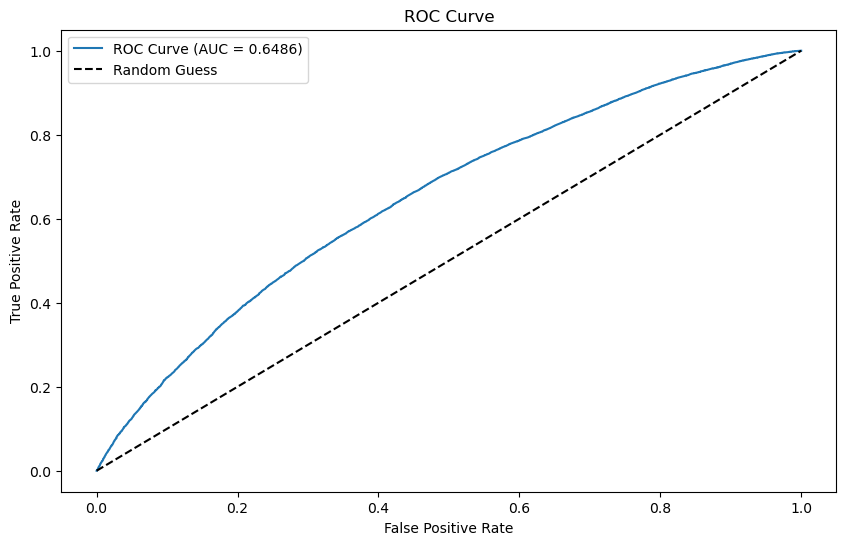

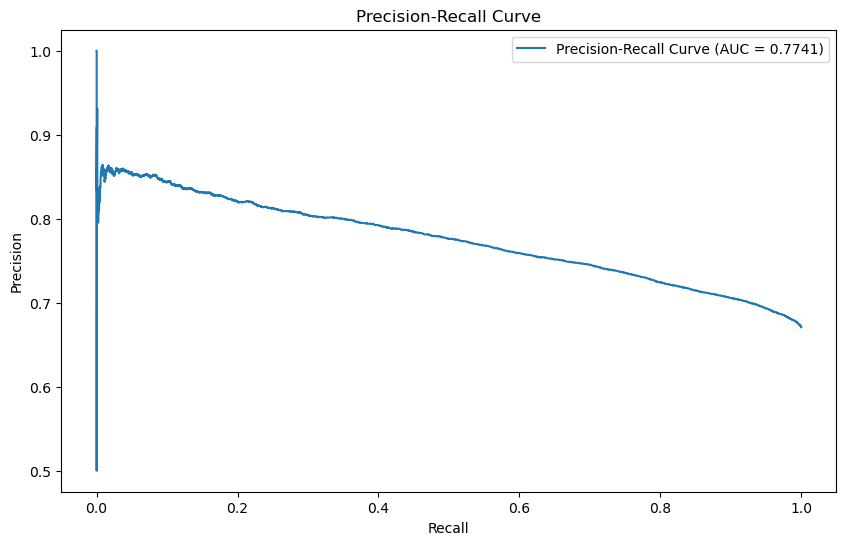

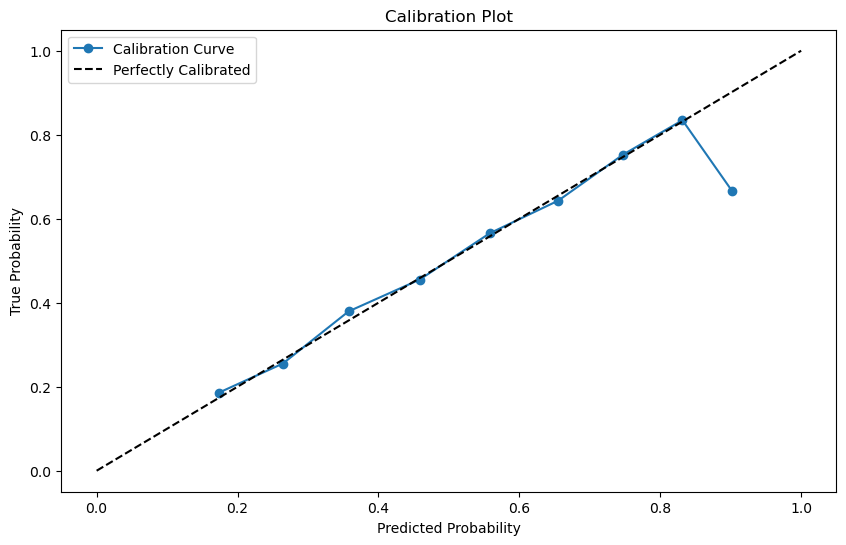

In [52]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=42, stratify=y_dummy)

# Update Logistic Regression model with best parameters
best_params = {
     'C': 0.15808394808776696,
    
     'class_weight': None,
     'max_iter': 3000,
     'penalty': 'l1',
     'solver': 'liblinear'
 }

rand_params = {
    #'C': 0.15808394808776696,
    #'class_weight': None,
    #'max_iter': 100,
    #'penalty': None,
    #'solver': 'liblinear'
}

# Initialize and train the Logistic Regression model
model = LogisticRegression(**best_params) # switch between best_params & rand_params
#model.fit(X_train_resampled, y_train_resampled)
model.fit(X_train, y_train)

# Helper function to convert "Yes"/"No" to numeric
def convert_input(value):
    return 1 if value == "Yes" else 0

# Scale victim age (same scaling as done in the dataset) for the interface
def scale_victim_age(victim_age):
    return scaler.transform([[victim_age]])[0][0]  # Scale based on the previously fitted scaler

# Function to format confusion matrix (improved clarity)
def format_confusion_matrix(matrix):
    return (
        f"Confusion Matrix:\n"
        f"                    Predicted: Non-Firearm       Predicted: Firearm\n"
        f"Actual: Non-Firearm {matrix[0][0]:<6}                       {matrix[0][1]:<6}\n"
        f"Actual: Firearm         {matrix[1][0]:<6}                       {matrix[1][1]:<6}"
    )

# Evaluate the model on the test data
y_pred = model.predict(X_test)
# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # Handle multi-class if applicable
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)
# average='weighted' Handle multi-class or imbalanced binary classification if applicable

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
balanced_accuracy = (recall + specificity) / 2
mcc = matthews_corrcoef(y_test, y_pred)
#print(format_confusion_matrix(cm))

# Calibration metrics
brier_score = brier_score_loss(y_test, y_pred_proba)

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

# Compute log-loss (cross-entropy)
cross_entropy = log_loss(y_test, y_pred_proba)
print(f"Cross-Entropy Loss: {cross_entropy:.4f}")

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cross-Entropy Loss: {cross_entropy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Brier Score: {brier_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix output
print("\nConfusion Matrix:")
print(f"                Predicted: Non-Firearm   Predicted: Firearm")
print(f"Actual: Non-Firearm     {tn:<16} {fp:<16}")
print(f"Actual: Firearm         {fn:<16} {tp:<16}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calibration Plot (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()


The double asterisks (**) in Python are used to unpack a dictionary into keyword arguments when calling a function or instantiating an object.

What Happens Here: best_params is a dictionary containing the best hyperparameters for the LogisticRegression model. The LogisticRegression constructor expects arguments like C, class_weight, max_iter, etc., as individual keyword arguments. Using **best_params unpacks the dictionary so that each key-value pair in the dictionary is passed as a separate argument to the LogisticRegression constructor: 'C': 0.15808394808776696 becomes C=0.15808394808776696 'class_weight': None becomes class_weight=None And so on...

Why Use ** Here? This approach is: Efficient: You don't need to manually specify each parameter individually in the constructor. Dynamic: If the dictionary changes (e.g., different parameters for another model), the code remains reusable and adaptable.

In [43]:
# Add a constant to the features for the intercept term (required for statsmodels)
X_train_with_intercept = sm.add_constant(X_train)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()

# Get the summary of the model, including p-values and other stats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.601911
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Weapon Category.1   No. Observations:               107457
Model:                          Logit   Df Residuals:                   107440
Method:                           MLE   Df Model:                           16
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                 0.04994
Time:                        17:57:44   Log-Likelihood:                -64680.
converged:                       True   LL-Null:                       -68080.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.8558      0.043    

## Logistic Regression with SMOTE once best parameters were identified using RandomizedSearchCV()

Accuracy: 0.6161
Precision: 0.6495
Recall: 0.6161
F1 Score: 0.6262
ROC-AUC: 0.6485
Precision-Recall AUC: 0.7738
Specificity: 0.5768
Cross-Entropy Loss: 0.6573
Balanced Accuracy: 0.5965
Matthews Correlation Coefficient: 0.2012
Brier Score: 0.2323
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.58      0.50     15157
           1       0.75      0.64      0.69     30897

    accuracy                           0.62     46054
   macro avg       0.60      0.61      0.59     46054
weighted avg       0.65      0.62      0.63     46054


Confusion Matrix:
                Predicted: Non-Firearm   Predicted: Firearm
Actual: Non-Firearm     8743             6414            
Actual: Firearm         11266            19631           


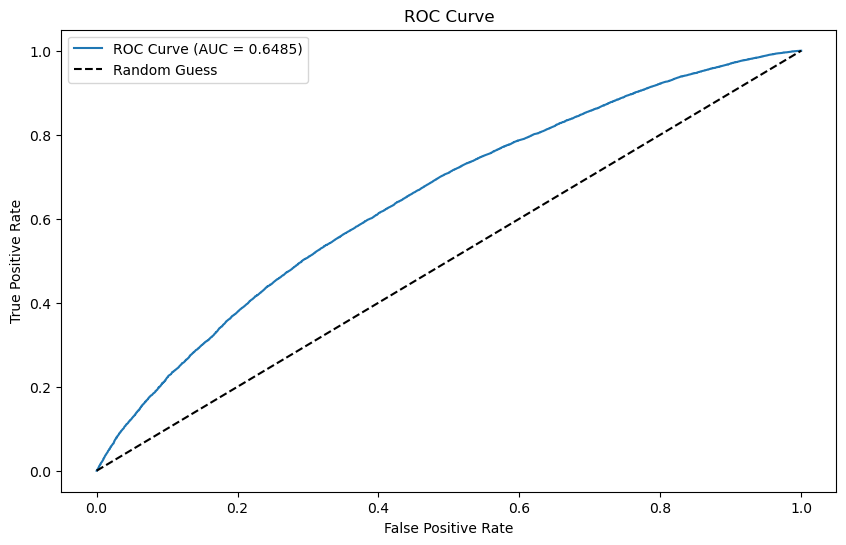

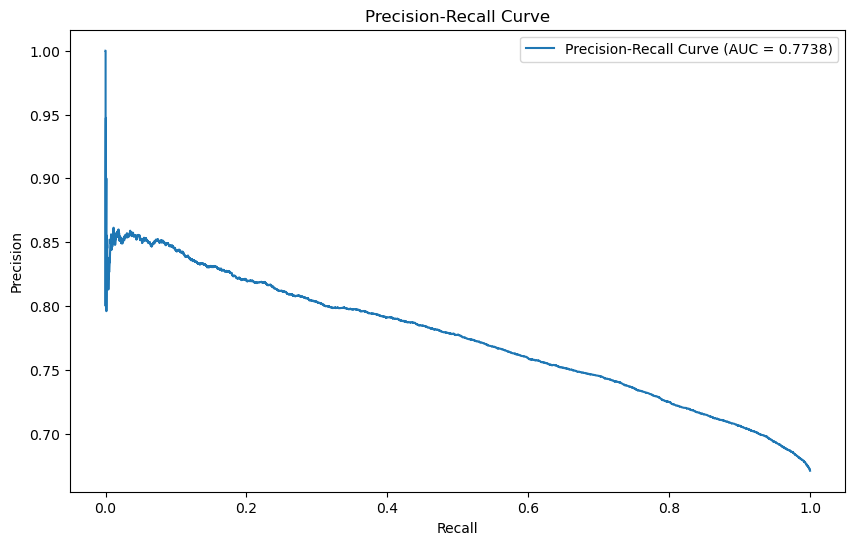

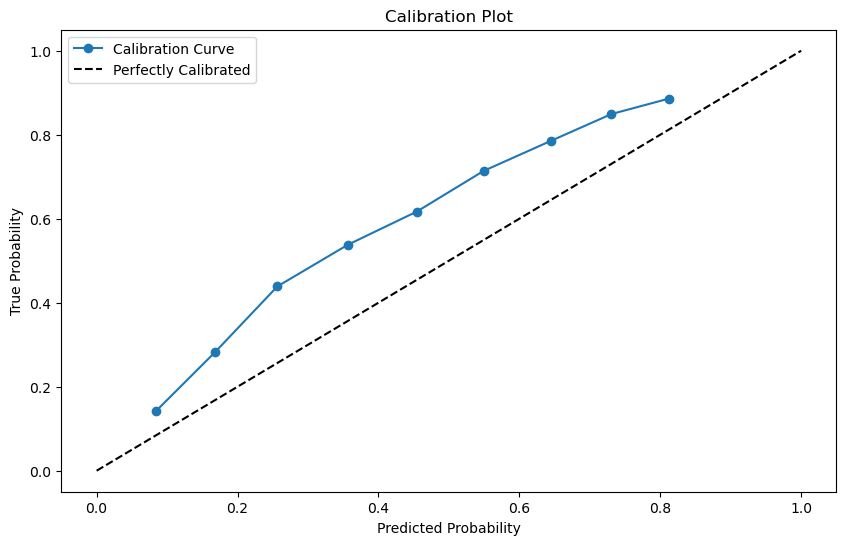

In [45]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=42, stratify=y_dummy)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Oversample the minority class

# Update Logistic Regression model with best parameters
best_params = {
     'C': 0.15808394808776696,
     'class_weight': None,
     'max_iter': 3000,
     'penalty': 'l1',
     'solver': 'liblinear'
    }

rand_params = {
    'C': 0.0001,
    # 'class_weight': None,
    'max_iter': 10000,
    'penalty': None,
    # 'solver': 'lbfgs'
      }

# Initialize and train the Logistic Regression model
model = LogisticRegression(**best_params) # switch between best_params & rand_params
model.fit(X_train_resampled, y_train_resampled)
#model.fit(X_train, y_train)

# Helper function to convert "Yes"/"No" to numeric
def convert_input(value):
    return 1 if value == "Yes" else 0

# Scale victim age (same scaling as done in the dataset) for the interface
def scale_victim_age(victim_age):
    return scaler.transform([[victim_age]])[0][0]  # Scale based on the previously fitted scaler

# Function to format confusion matrix (improved clarity)
def format_confusion_matrix(matrix):
    return (
        f"Confusion Matrix:\n"
        f"                    Predicted: Non-Firearm       Predicted: Firearm\n"
        f"Actual: Non-Firearm {matrix[0][0]:<6}                       {matrix[0][1]:<6}\n"
        f"Actual: Firearm         {matrix[1][0]:<6}                       {matrix[1][1]:<6}"
    )

# Evaluate the model on the test data
y_pred = model.predict(X_test)
# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)
# average='weighted' Handle multi-class or imbalanced binary classification if applicable

# Confusion matrix and related metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
balanced_accuracy = (recall + specificity) / 2
mcc = matthews_corrcoef(y_test, y_pred)
#print(format_confusion_matrix(cm))

# Calibration metrics
brier_score = brier_score_loss(y_test, y_pred_proba)

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

# Compute log-loss (cross-entropy)
cross_entropy = log_loss(y_test, y_pred_proba)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cross-Entropy Loss: {cross_entropy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Brier Score: {brier_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix output
print("\nConfusion Matrix:")
print(f"                Predicted: Non-Firearm   Predicted: Firearm")
print(f"Actual: Non-Firearm     {tn:<16} {fp:<16}")
print(f"Actual: Firearm         {fn:<16} {tp:<16}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calibration Plot (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()

Notes (ChatGPT):

Why Weighted Metrics Are Important After SMOTE

Class Distribution in Training and Test Sets:
SMOTE alters the class distribution only in the training data, making the classes balanced for model learning.
However, the test set remains imbalanced (as it should), so evaluation metrics must account for the natural class imbalance in the test data.
                                                                                 
Avoiding Overestimation of Model Performance:
After SMOTE, the model might show improved performance for the minority class (firearm) because of the balanced training data.
Weighted metrics ensure that this improvement is measured fairly by considering the contribution of both classes in the test data.
    
Real-World Class Distribution:
In practical scenarios, the model will encounter the natural class imbalance. Weighted metrics simulate this scenario by assigning proportional importance to both classes.
    
Key Adjustments with SMOTE
Use average='weighted' for precision, recall, and F1 score to balance the contributions of both classes.
Include class-specific metrics (default in classification_report) to observe the individual class performance.
Evaluate additional metrics like ROC-AUC and cross-entropy loss, which remain unaffected by class imbalance.

The calibration plot shows the relationship between predicted probabilities and actual observed probabilities for a classification model.
                                                                                                              
Interpretation:
Diagonal Line (Black, Dashed): Represents a perfectly calibrated model where predicted probabilities exactly match the observed probabilities.
Blue Line (Empirical Calibration Curve): Represents the actual calibration of the model.
                                                                                                              
Observations:
The blue curve is above the diagonal for most of the range, meaning that the model is under-confident in its probability estimates.
Example: If the model predicts a probability of 0.4, the true proportion of positive cases is actually higher (closer to 0.5 or more).
This suggests that the model systematically underestimates the probability of the positive class.
The model could benefit from calibration techniques like Platt scaling or isotonic regression to bring the predictions closer to the ideal diagonal.
    

The Precision-Recall (PR) curve highlights the trade-off between precision and recall for a classification model.
    
Key Observations:
    
Overall Shape:
Precision is highest at very low recall values, which is expected since the model is very selective at those points.
As recall increases, precision gradually decreases, indicating that the model retrieves more relevant instances but at the cost of including more false positives.
    
AUC (0.7738):
The area under the precision-recall curve (AUC-PR) is 0.7738, which suggests reasonably good performance, especially in an imbalanced dataset, where PR curves are often more informative than ROC curves.
    
Steady Decline in Precision:
There is no abrupt drop in precision, which suggests the model maintains reasonable performance across different classification thresholds.
However, precision steadily declines as recall increases, indicating that more retrieved positive cases come with a higher false positive rate.
    
Interpretation:
If this model is applied in a high-risk setting (e.g., fraud detection, medical diagnosis, firearm classification), a higher precision threshold might be required to minimize false positives.
If high recall is prioritized (e.g., catching all possible cases), precision would suffer.
The relatively high AUC-PR (0.7738) suggests the model performs well but could still be optimized depending on the use case.

    

In [47]:
# Add a constant to the resampled features for the intercept term
X_train_resampled_with_intercept = sm.add_constant(X_train_resampled)

# Fit the logistic regression model using statsmodels on the resampled data
logit_model_resampled = sm.Logit(y_train_resampled, X_train_resampled_with_intercept)
result_resampled = logit_model_resampled.fit()

# Get the summary of the model, including p-values and other stats
print(result_resampled.summary())

Optimization terminated successfully.
         Current function value: 0.656898
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Weapon Category.1   No. Observations:               144182
Model:                          Logit   Df Residuals:                   144165
Method:                           MLE   Df Model:                           16
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                 0.05230
Time:                        17:58:18   Log-Likelihood:                -94713.
converged:                       True   LL-Null:                       -99939.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.6377      0.036    

## Gradio Interface

## Choose any model from above and run Gradio

In [54]:
# Gradio interface function with simplified dropdowns
def gradio_interface(
    region, season, relationship, agency,
    victim_sex, perpetrator_sex, victim_ethnicity, perpetrator_ethnicity, 
    victim_age
):
    # Define mapping for dropdowns to dummy variables
    region_mapping = {"Midwest": [0, 0, 0], "Northeast": [1, 0, 0], "South": [0, 1, 0], "West": [0, 0, 1]}
    season_mapping = {"Autumn": [0, 0, 0], "Spring": [1, 0, 0], "Summer": [0, 1, 0], "Winter": [0, 0, 1]}
    relationship_mapping = {"Acquaintance": [0, 0, 0], "Family": [1, 0, 0], "Lover": [0, 1, 0], "Stranger": [0, 0, 1]}
    agency_mapping = {"Municipal Police": [0, 0], "Other Police": [1, 0], "Sheriff": [0, 1]}
    sex_mapping = {"Male": 1, "Female": 0}
    ethnicity_mapping = {"Hispanic": 0, "Not Hispanic": 1}

    # Map selected values to dummy variables
    region_dummies = region_mapping[region]
    season_dummies = season_mapping[season]
    relationship_dummies = relationship_mapping[relationship]
    agency_dummies = agency_mapping[agency]

    # Map sex and ethnicity to numeric values
    victim_sex_numeric = sex_mapping[victim_sex]
    perpetrator_sex_numeric = sex_mapping[perpetrator_sex]
    victim_ethnicity_numeric = ethnicity_mapping[victim_ethnicity]
    perpetrator_ethnicity_numeric = ethnicity_mapping[perpetrator_ethnicity]

    # Compile input features
    input_features = (
        region_dummies +
        season_dummies +
        relationship_dummies +
        agency_dummies +
        [victim_sex_numeric, perpetrator_sex_numeric, victim_ethnicity_numeric, perpetrator_ethnicity_numeric] +
        [scale_victim_age(victim_age)]  # Scale victim age for the model
    )
    
    # Model predictions
    input_pred = model.predict([input_features])[0]  # Single prediction
    input_pred_proba = model.predict_proba([input_features])[0]  # Probabilities for both classes

    # Map numeric prediction to labels
    prediction_label = "Firearm" if input_pred == 1 else "Non-Firearm"

    # Compute evaluation metrics
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    class_report = classification_report(y_test, y_pred)

    # Improved confusion matrix format
    formatted_conf_matrix = format_confusion_matrix(conf_matrix)

    return (
        f"Prediction: {prediction_label}",
        f"Probability of Firearm Being Used: {input_pred_proba[1]:.2f}",
        f"Probability of Firearm Not Being Used: {input_pred_proba[0]:.2f}",
        f"{formatted_conf_matrix}",
        f"Accuracy: {accuracy:.2f}",
        f"Recall: {recall:.2f}",
        f"Precision: {precision:.2f}",
        f"F1 Score: {f1:.2f}",
        f"Classification Report:\n{class_report}"
        )


# Custom CSS for the Gradio interface
custom_css = """
body {
    background: linear-gradient(to bottom right, #6a11cb, #2575fc);
    color: white;
    font-family: Arial, sans-serif;
}
.error-text {
    color: red;
    font-weight: bold;
}
"""

# Gradio interface with simplified dropdowns
gr.Interface(
    title="Weapon Use Prediction",
    description="**Instructions:** Select one option per category.",
    fn=gradio_interface,
    inputs=[
        gr.Dropdown(["Midwest", "Northeast", "South", "West"], value="Midwest", label="Region"),
        gr.Dropdown(["Autumn", "Spring", "Summer", "Winter"], value="Autumn", label="Season"),
        gr.Dropdown(["Acquaintance", "Family", "Lover", "Stranger"], value="Acquaintance", label="Relationship"),
        gr.Dropdown(["Municipal Police", "Other Police", "Sheriff"], value="Municipal Police", label="Agency"),
        gr.Dropdown(["Male", "Female"], value="Male", label="Victim Sex"),
        gr.Dropdown(["Male", "Female"], value="Male", label="Perpetrator Sex"),
        gr.Dropdown(["Hispanic", "Not Hispanic"], value="Hispanic", label="Victim Ethnicity"),
        gr.Dropdown(["Hispanic", "Not Hispanic"], value="Hispanic", label="Perpetrator Ethnicity"),
        gr.Slider(0, 100, step=1, value=0, label="Victim Age"),
    ],
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Probability of Firearm Being Used"),
        gr.Textbox(label="Probability of Firearm Not Being Used"),
        gr.Textbox(label="Confusion Matrix"),
        gr.Textbox(label="Accuracy"),
        gr.Textbox(label="Recall"),
        gr.Textbox(label="Precision"),
        gr.Textbox(label="F1 Score"),
        gr.Textbox(label="Classification Report"),
    ],
    css=custom_css,
).launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
